In [1]:
!pip install -U scikit-image

In [2]:
pip install --upgrade scikit-image

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install tqdm

In [4]:
import pandas as pd
import numpy as np
import cv2
import os
from skimage.feature import graycomatrix, graycoprops, hog
from skimage import io, color, exposure
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

In [5]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [6]:
image_size = (128, 128)  # Resize all images to 128x128 for uniformity


In [7]:
def extract_glcm_features(image, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    features = [
        graycoprops(glcm, 'contrast')[0, 0],
        graycoprops(glcm, 'dissimilarity')[0, 0],
        graycoprops(glcm, 'homogeneity')[0, 0],
        graycoprops(glcm, 'energy')[0, 0],
        graycoprops(glcm, 'correlation')[0, 0],
        graycoprops(glcm, 'ASM')[0, 0],
    ]
    return features


In [8]:
def extract_hog_features(image):
    features, _ = hog(image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      feature_vector=True)
    return features


In [9]:
def extract_features_labels(data_path):
    features = []
    labels = []

    for label in os.listdir(data_path):
        class_path = os.path.join(data_path, label)
        if not os.path.isdir(class_path):
            continue

        for file in tqdm(os.listdir(class_path), desc=f"Processing {label}"):
            file_path = os.path.join(class_path, file)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size)

            # Extract features
            glcm_feats = extract_glcm_features(img)
            hog_feats = extract_hog_features(img)
            combined_feats = np.hstack((glcm_feats, hog_feats))

            features.append(combined_feats)
            labels.append(label)

    return np.array(features), np.array(labels)


In [10]:
data_path = "ml_dataset"  # Replace with your actual dataset path
X, y = extract_features_labels(data_path)


Processing Normal_cases: 100%|███████████████████████████████████████████████████████| 417/417 [01:29<00:00,  4.66it/s]


In [11]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [13]:
data_path

'ml_dataset'

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [15]:
print("Encoded Labels:", np.unique(y_encoded)) #since it is having 3 label so auc-roc curve is not possible

Encoded Labels: [0 1 2]


📊 Random Forest Results:
Accuracy: 0.9045454545454545
              precision    recall  f1-score   support

           0       1.00      0.38      0.55        29
           1       0.95      1.00      0.97       109
           2       0.84      0.96      0.90        82

    accuracy                           0.90       220
   macro avg       0.93      0.78      0.81       220
weighted avg       0.91      0.90      0.89       220



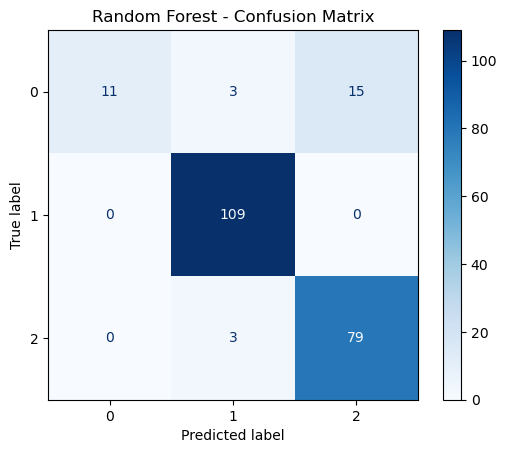

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("📊 Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))
rf_cm = confusion_matrix(y_test, rf_pred)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf.classes_)
rf_disp.plot(cmap=plt.cm.Blues)
plt.title("Random Forest - Confusion Matrix")
plt.show()

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

📊 KNN Results:
Accuracy: 0.7954545454545454
              precision    recall  f1-score   support

           0       0.68      0.45      0.54        29
           1       0.86      0.85      0.86       109
           2       0.74      0.84      0.79        82

    accuracy                           0.80       220
   macro avg       0.76      0.71      0.73       220
weighted avg       0.79      0.80      0.79       220



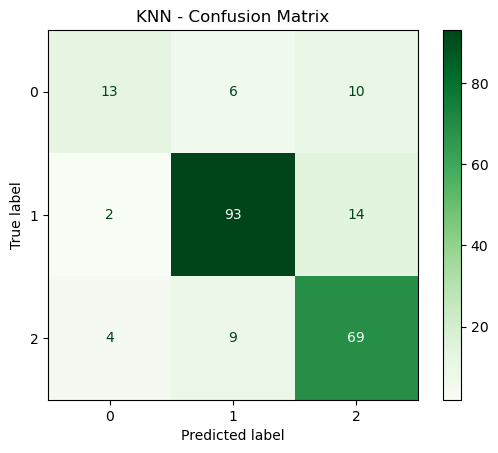

In [18]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

print("📊 KNN Results:")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))
knn_cm = confusion_matrix(y_test, knn_pred)
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=knn.classes_)
knn_disp.plot(cmap=plt.cm.Greens)
plt.title("KNN - Confusion Matrix")
plt.show()

In [19]:
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print("📊 SVM Results:")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

📊 SVM Results:
Accuracy: 0.9863636363636363
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        29
           1       0.99      1.00      1.00       109
           2       0.98      0.99      0.98        82

    accuracy                           0.99       220
   macro avg       0.99      0.97      0.98       220
weighted avg       0.99      0.99      0.99       220



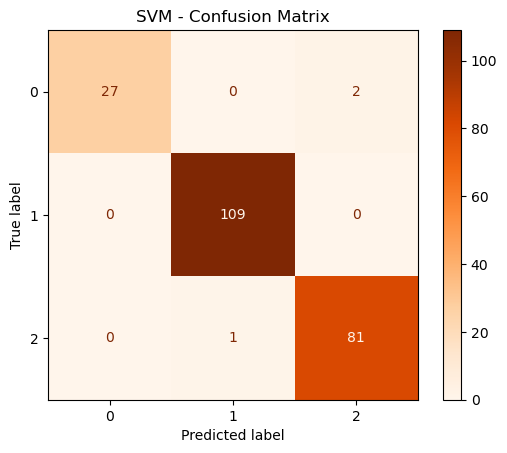

In [20]:
svm_cm = confusion_matrix(y_test, svm_pred)
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=svm.classes_)
svm_disp.plot(cmap=plt.cm.Oranges)
plt.title("SVM - Confusion Matrix")
plt.show()

In [21]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Constants
IMAGE_SIZE = (128, 128)

# ---------------------
# Feature extractors
# ---------------------
def extract_glcm_features(image):
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    return [graycoprops(glcm, prop)[0, 0] for prop in props]

def extract_hog_features(image):
    features, _ = hog(image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      feature_vector=True)
    return features

def extract_features_labels(data_path):
    features = []
    labels = []

    for label in os.listdir(data_path):
        class_path = os.path.join(data_path, label)
        if not os.path.isdir(class_path):
            continue

        for file in tqdm(os.listdir(class_path), desc=f"Processing {label}"):
            file_path = os.path.join(class_path, file)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)

            try:
                glcm_feats = extract_glcm_features(img)
                hog_feats = extract_hog_features(img)
                combined_feats = np.hstack((glcm_feats, hog_feats))
                features.append(combined_feats)
                labels.append(label)
            except:
                continue

    return np.array(features), np.array(labels)

# ---------------------
# Load and preprocess data
# ---------------------
data_path = "ml_dataset"  # change to your actual path
X, y = extract_features_labels(data_path)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# ---------------------
# Train and evaluate classifiers
# ---------------------
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', C=1.0, random_state=42)
}

for name, model in models.items():
    print(f"\n🔍 Training and Evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy ({name}): {acc:.4f}")
    print(f"📊 Classification Report for {name}:\n{classification_report(y_test, y_pred, target_names=le.classes_)}")


Processing Normal_cases: 100%|███████████████████████████████████████████████████████| 417/417 [01:27<00:00,  4.77it/s]



🔍 Training and Evaluating: KNN
✅ Accuracy (KNN): 0.9545
📊 Classification Report for KNN:
                 precision    recall  f1-score   support

   Bengin_cases       1.00      0.66      0.79        29
Malignant_cases       1.00      1.00      1.00       109
   Normal_cases       0.89      1.00      0.94        82

       accuracy                           0.95       220
      macro avg       0.96      0.89      0.91       220
   weighted avg       0.96      0.95      0.95       220


🔍 Training and Evaluating: Random Forest
✅ Accuracy (Random Forest): 0.9045
📊 Classification Report for Random Forest:
                 precision    recall  f1-score   support

   Bengin_cases       1.00      0.38      0.55        29
Malignant_cases       0.95      1.00      0.97       109
   Normal_cases       0.84      0.96      0.90        82

       accuracy                           0.90       220
      macro avg       0.93      0.78      0.81       220
   weighted avg       0.91      0.90      0.


🔍 Training and Evaluating: KNN
✅ Accuracy (KNN): 0.9545
📊 Classification Report for KNN:
                 precision    recall  f1-score   support

   Bengin_cases       1.00      0.66      0.79        29
Malignant_cases       1.00      1.00      1.00       109
   Normal_cases       0.89      1.00      0.94        82

       accuracy                           0.95       220
      macro avg       0.96      0.89      0.91       220
   weighted avg       0.96      0.95      0.95       220


🔍 Training and Evaluating: Random Forest
✅ Accuracy (Random Forest): 0.9045
📊 Classification Report for Random Forest:
                 precision    recall  f1-score   support

   Bengin_cases       1.00      0.38      0.55        29
Malignant_cases       0.95      1.00      0.97       109
   Normal_cases       0.84      0.96      0.90        82

       accuracy                           0.90       220
      macro avg       0.93      0.78      0.81       220
   weighted avg       0.91      0.90      0.

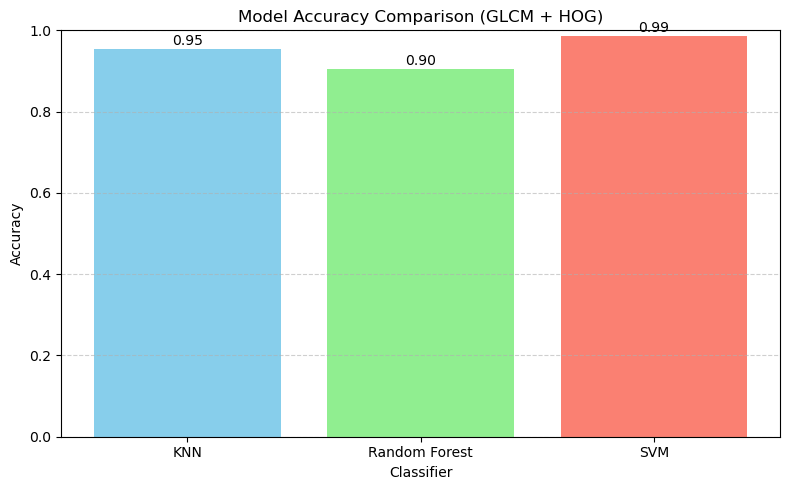

In [22]:
import matplotlib.pyplot as plt

# Store results for plotting
accuracies = []

for name, model in models.items():
    print(f"\n🔍 Training and Evaluating: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append((name, acc))

    print(f"✅ Accuracy ({name}): {acc:.4f}")
    print(f"📊 Classification Report for {name}:\n{classification_report(y_test, y_pred, target_names=le.classes_)}")

# --------------------------------
# 📈 Plot Accuracy Comparison
# --------------------------------
model_names = [name for name, _ in accuracies]
accuracy_scores = [score for _, score in accuracies]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracy_scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Model Accuracy Comparison (GLCM + HOG)")
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
